Loading model from color_correction_cnn.h5


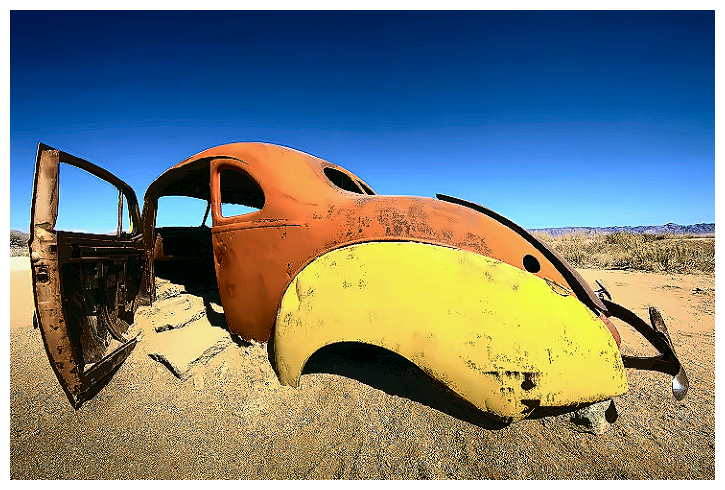

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Add
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf

# Custom loss function combining MSE and SSIM
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse_loss + ssim_loss

# Function to create an enhanced CNN for face color correction with residual connections
def create_color_correction_cnn(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual block
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(res)
    x = Add()([x, res])

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss)
    return model

# Function to load face dataset and apply random color shifts
def load_and_prepare_dataset(dataset_path, image_size=(128, 128)):
    X_train = []
    y_train = []

    for filename in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            shift = np.random.randint(-20, 20, size=(1, 3), dtype=np.int32)
            shifted_img = np.clip(img + shift, 0, 255).astype(np.uint8)
            X_train.append(shifted_img)
            y_train.append(img)

    X_train = np.array(X_train) / 255.0
    y_train = np.array(y_train) / 255.0
    return X_train, y_train

# Function to perform LAB-based face color correction only
def correct_face_color_lab(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    shift_value = 5
    a = np.clip(a - shift_value, 0, 255)
    lab_corrected = cv2.merge((l, a, b))
    return cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2RGB)

# Function to enhance overall image contrast selectively
def enhance_contrast_selective(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    mean_l = np.mean(l)

    # Apply contrast enhancement only to faded regions (low mean L)
    if mean_l < 120:
        l = cv2.equalizeHist(l)
    enhanced_image = cv2.merge((l, a, b))
    return cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2RGB)

# Function to reduce noise in the image
def reduce_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 5, 5, 7, 21)

# Create and train the CNN using real face data
def train_and_save_cnn(dataset_path, model_path="color_correction_cnn.h5"):
    X_train, y_train = load_and_prepare_dataset(dataset_path)
    model = create_color_correction_cnn()
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    model.save(model_path)
    print(f"Model saved at {model_path}")
    return model

# Function to load the saved CNN model and check input shape
def load_color_correction_cnn(model_path="color_correction_cnn.h5"):
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model = load_model(model_path, custom_objects={'combined_loss': combined_loss})
        # Check if the model's input shape matches the expected shape
        if model.input_shape[1:3] != (128, 128):
            print("Input shape mismatch. Retraining the model with the correct input shape.")
            os.remove(model_path)
            return train_and_save_cnn(dataset_path, model_path)
        return model
    else:
        print("Model not found. Please train the model first.")
        return train_and_save_cnn(dataset_path, model_path)

# Function to apply face color correction using the trained CNN
def correct_face_color_with_cnn(image, face_region, model):
    face_patch = cv2.resize(face_region, (128, 128)) / 255.0
    corrected_patch = model.predict(face_patch[np.newaxis, ...])[0]
    corrected_patch = (corrected_patch * 255).astype(np.uint8)
    corrected_patch = cv2.resize(corrected_patch, (face_region.shape[1], face_region.shape[0]))
    return corrected_patch

# Function to enhance background by reducing orange saturation in non-face areas
def enhance_background(image, mask):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    non_face_mask = np.ones_like(mask) - mask

    # Reduce saturation in non-face areas
    a[non_face_mask == 1] = np.clip(a[non_face_mask == 1] - 5, 0, 255)

    lab_corrected = cv2.merge((l, a, b))
    return cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2RGB)

# Simple convolution to enhance image details (sharpening)
def apply_simple_convolution(image):
    kernel = np.array([[0, -0.5, 0], [-0.5, 3, -0.5], [0, -0.5, 0]])
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image

# Final function to apply all enhancements while keeping face correction intact
def correct_face_and_enhance_background(image_path, model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    mask = np.zeros_like(gray, dtype=np.uint8)
    for (x, y, w, h) in faces:
        face_region = img_rgb[y:y+h, x:x+w]

        # Apply CNN-based correction
        corrected_face_cnn = correct_face_color_with_cnn(img_rgb, face_region, model)

        # Apply LAB-based correction for comparison
        corrected_face_lab = correct_face_color_lab(face_region)

        # Blend CNN and LAB corrections
        corrected_face = cv2.addWeighted(corrected_face_cnn, 0.6, corrected_face_lab, 0.4, 0)

        # Create a mask with blurred edges for blending
        face_mask = np.zeros_like(gray)
        face_mask[y:y+h, x:x+w] = 255
        blurred_mask = cv2.GaussianBlur(face_mask, (7, 7), 0)

        # Blend corrected face region with the original image using the blurred mask
        for c in range(3):
            img_rgb[y:y+h, x:x+w, c] = img_rgb[y:y+h, x:x+w, c] * (1 - blurred_mask[y:y+h, x:x+w] / 255.0) + corrected_face[:, :, c] * (blurred_mask[y:y+h, x:x+w] / 255.0)
        mask[y:y+h, x:x+w] = 1

        # Apply mild sharpening to the blended face region
        img_rgb[y:y+h, x:x+w] = apply_simple_convolution(img_rgb[y:y+h, x:x+w])

    # Apply contrast enhancement selectively
    corrected_image = enhance_contrast_selective(img_rgb)

    # Reduce noise in the entire image
    corrected_image = reduce_noise(corrected_image)

    corrected_image = enhance_background(corrected_image, mask)
    final_image = apply_simple_convolution(corrected_image)
    return final_image

# Path to your dataset of face images
dataset_path = r"C:\Users\deepu\Downloads\mydataset\mydataset"
model_path = "color_correction_cnn.h5"

# Train and save the model if it doesn't exist
color_correction_cnn = load_color_correction_cnn(model_path)

# Path to the image you want to process
image_path = r"C:\Users\deepu\Downloads\36_20131124173035_1162738_medium.jpg"

# Apply color correction and background enhancement
if color_correction_cnn:
    corrected_image = correct_face_and_enhance_background(image_path, color_correction_cnn)

    # Display the corrected image
    plt.figure(figsize=(10, 5))
    plt.imshow(corrected_image)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('enhanced-1.jpg')
    plt.show()